In [3]:
import sys, pickle
sys.path.append('../src')
import numpy as np
from scipy.linalg import svd
from scipy.stats import permutation_test
from tqdm import tqdm
from matplotlib import colormaps
import matplotlib.pyplot as plt
from train_funcs import load_models, read_realistic_input
from helper_funcs import *
rng = np.random.default_rng()

In [4]:
AUD_MAP_TYPE, REC_PLASTICITY, HVC_COND, TID = 'neighbor', 'EIIE', 'mature_hvc', '0'
fname = '../results/EIrec_weights_evolve_%s_map_%s_%s_%s.pkl' \
      % (AUD_MAP_TYPE, REC_PLASTICITY, HVC_COND, TID)
with open(fname, 'rb') as f:
    TS, d = pickle.load(f)
    WsEE, WsEI = d['E2E'], d['E2I']
NE = WsEE['JEE'][0].shape[0]
NI = NE // 4
fname = '../realistic_auditory_processing/learned_song_responses.npz'
res = load_models('../results/', AUD_MAP_TYPE, REC_PLASTICITY, HVC_COND, TID)
_, _, netE2E, netE2I, aud_mapping = res
aud = read_realistic_input(fname, NE, mean=0, scale=2, mapping=aud_mapping, mapping_args=None)[0]
aud = aud['ctrl'].mean(axis=0).T # take mean

(800,)


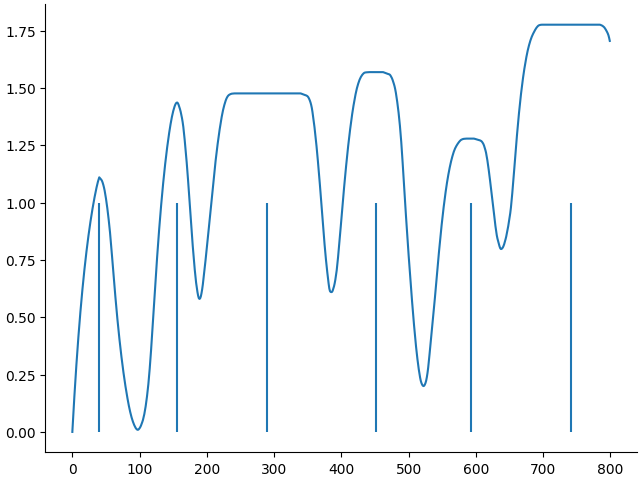

In [5]:
from scipy.signal import find_peaks
aux = np.abs(aud).mean(axis=1)
plt.plot(aux);
print(aux.shape)
plt.vlines(find_peaks(aux)[0], 0, 1)
aud = aud[find_peaks(aux)[0]]

In [ ]:
svds_E2E, svds_E2I = [], []
for w in WsEE['JEE']:
    J_E2E = get_J(netE2E, JEE=w.toarray())
    svds_E2E.append(svd(J_E2E))
if REC_PLASTICITY == 'EIIE':
    for wei, wie in zip(WsEI['JEI'], WsEI['JIE']):
        J_E2I = get_J(netE2I, JEI=wei.toarray(), JIE=wie.toarray())
        svds_E2I.append(svd(J_E2I))
elif REC_PLASTICITY == 'EI':
    for wie in Ws['JEI']:
        J_E2I = get_J(netE2I, JIE=wie.toarray())
        svds_E2I.append(svd(J_E2I))

KeyboardInterrupt: 

In [8]:
def plot_change(svds, song, mark_outlier_modes):
    change, i_landscape, i_nonland = characterize_change(svds)
    # mem_enc, i_memory, i_nonmem = characterize_memory(svds, song, 'left')
    mem_enc, i_memory, i_nonmem = characterize_memory(svds, song, 'right')

    print(i_landscape + 1, i_memory + 1)
    
    fig, ax = plt.subplots(1, 2, figsize=(3.8,2))
    
    ax[0].plot(TS, change, c='grey', alpha=0.1, lw=1, zorder=-1)
    ax[0].plot(TS, change[:,i_nonland].mean(axis=1), c='k', ls='--', zorder=1)
    if mark_landscape_mode:
        ax[0].plot(TS, change[:,i_landscape], c='r', lw=1, zorder=2)
        # ax[0].text(change.shape[0], 0.9, 'landscape modes', ha='right', va='bottom', 
        #            color='r', zorder=2)
    ax[0].set(ylabel='change\nduring learning', yticks=[0, 1], ylim=[-0.05, 1])
    ax[0].set_xlabel('training trial', va='top')
    ax[1].set_rasterization_zorder(0)
    
    ax[1].plot(TS, mem_enc[:,i_nonmem], c='grey', alpha=0.1, lw=1, zorder=-1)
    ax[1].plot(TS, mem_enc[:,i_nonmem].mean(axis=1), c='k', ls='--', zorder=1)
    ax[1].plot(TS, mem_enc[:,i_memory], c='b', lw=1, alpha=1, zorder=1)
    ax[1].text(change.shape[0], 0.7, 'memory modes', ha='right', c='b')
    ax[1].set(ylabel='memory encoding\nstrength', ylim=[-0.05, 1])
    ax[1].set_xlabel('training trial', va='top')
    ax[1].set_rasterization_zorder(0)

    return fig, ax

[2] [  4   5  12  13  19  31  32  33  35  40  47  51  59  63  65  81  97 118
 123 142]


ValueError: x and y must have same first dimension, but have shapes (42,) and (12, 100)

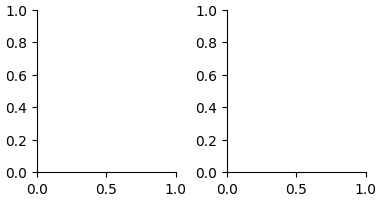

In [9]:
fig, ax = plot_change(svds_E2E, aud, False)
# fig.savefig('../svg/supplementary/mode_learning_curves_realistic_E2E.svg')

In [ ]:
for s, l in zip((svds_E2E, svds_E2I), ('E2E', 'E2I')):
    svd_pre, svd_post = s[0], s[-1]
    fig, ax = plt.subplots(1, figsize=(3,2), sharex='all')
    ax.plot(svd_pre[1], label='before learning')
    ax.plot(svd_post[1], label='after learning')
    ax.axhline(0, ls=':', c='k')
    ax.set(ylabel='J singular values', ylim=[-0.5, 1.5])
    ax.legend()
    i_jump = np.argmax(np.abs(np.gradient(svd_pre[1]))[100:200]) + 100
    ax.set(xlabel='Index', xticks=[0, i_jump, 350, 700])
    fig.savefig('../svg/supplementary/svd_J_full_realistic_%s.svg' % l)

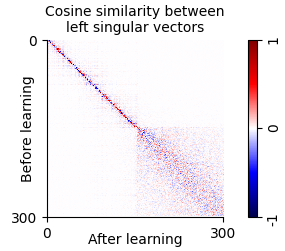

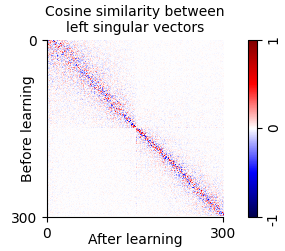

In [22]:
for s, l in zip((svds_E2E, svds_E2I), ('E2E', 'E2I')):
    svd_pre, svd_post = s[0], s[5]
    fig, ax = plt.subplots(1, figsize=(3, 2.5))
    i = 300
    im = ax.imshow(svd_pre[0][:,:i].T @ svd_post[0][:,:i], vmin=-1, vmax=1, 
                   interpolation='none', cmap='seismic', aspect=1)
    cax = fig.colorbar(im, ax=ax, fraction=0.04)
    cax.set_ticks([-1,0,1], labels=[-1,0,1], rotation=90)
    ax.set(xticks=[0,i], yticks=[0,i],
           title='Cosine similarity between\nleft singular vectors')
    ax.set_xlabel('\nAfter learning', va='bottom')
    ax.set_ylabel('\nBefore learning', va='top')
    fig.savefig('../svg/supplementary/left_sv_similarity_full_realistic_%s.svg' % l)

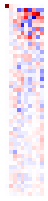

In [10]:
fig, ax = plt.subplots(1, figsize=(2,2))
i = 10
ax.imshow(svds_E2E[0][0][:,:50].T @ svds_E2E[-1][0][:,:i], vmin=-1, vmax=1, 
          interpolation='none', cmap='seismic', aspect=1)
ax.set_axis_off()
fig.savefig('../svg/supplementary/left_sv_similarity_zoomin_realistic_E2E.png')